# Identificação do objeto do comentário feito no tweet

[Voltar ao Índice](../00_indice.ipynb)

Ao verificar manualmente a performance do [modelo de detecção de discursos violentos](20_modelo_bert_com_tensorflow.ipynb), percebemos que respostas a tweets de candidatos muitas vezes atacam um adversário desse candidato; em outras palavras, o alvo (ou objeto) do ataque não é o candidato mencionado, mas outra pessoa. Como nosso objetivo era identificar ataques direcionados aos candidatos, precisamos criar um modelo que informe se um tweet é direcionado ao candidato mencionado ou não. É isso que faremos aqui.

**ATTENTION:** This notebook uses data that is not available in this project due to legal restrictions by the Brazilian Personal Data Protection Law ([LGPD](https://www.planalto.gov.br/ccivil_03/_ato2015-2018/2018/lei/l13709.htm)).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from pathlib import Path

import xavy.explore as xe
import xavy.dataframes as xd
import xavy.utils as xu
import xavy.text as xt
import xavy.mltools as ml

## Funções

In [2]:
def load_saved_mentions(data_dir):
    result_df = pd.concat([pd.read_csv(f, dtype={'in_reply_to_user_id':str}) for f in Path(data_dir).rglob('*.csv')], ignore_index=True)
    result_df['created_at'] = pd.to_datetime(result_df['created_at'], format='%Y-%m-%d %H:%M:%S+00:00', utc=True).dt.tz_convert('America/Sao_Paulo')
    return result_df

In [3]:
def load_annotations(annotated_files):
    annotated_df = pd.concat([pd.read_csv(f, low_memory=False, dtype={'id': str}) for f in annotated_files], ignore_index=True)
    annotated_df = annotated_df.loc[~annotated_df['not_the_target'].isnull()]
    annotated_df['not_the_target'] = annotated_df['not_the_target'].astype(int)
    utc_pos = annotated_df['created_at'].str.contains('+00:00', regex=False)
    bsb_pos = annotated_df['created_at'].str.contains('-03:00', regex=False)
    annotated_df.loc[utc_pos, 'created_at'] = pd.to_datetime(annotated_df.loc[utc_pos, 'created_at'], format='%Y-%m-%d %H:%M:%S+00:00', utc=True).dt.tz_convert('America/Sao_Paulo')
    annotated_df.loc[bsb_pos, 'created_at'] = pd.to_datetime(annotated_df.loc[bsb_pos, 'created_at'], format='%Y-%m-%d %H:%M:%S-03:00', utc=False).dt.tz_localize('America/Sao_Paulo')
    annotated_df = annotated_df.drop_duplicates()
    return annotated_df

## Produzindo dados para anotação

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
# Carrega os dados:
annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados.csv', 
                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados.csv']
annotated_df = load_annotations(annotated_files)

In [6]:
# Carrega os dados:
mentions_df = load_saved_mentions('../../tweets/scored/')

# Remove tweets já anotados:
assert mentions_df['id'].dtype == annotated_df['id'].dtype
mentions_df = mentions_df.loc[~mentions_df['id'].isin(annotated_df['id'])]

# Remove tweets antigos:
last_annotation = annotated_df['created_at'].max()
mentions_df = mentions_df.loc[mentions_df['created_at'] > last_annotation]

# Ignore tweets containing only images:
only_image_regex = '^(?:@[A-Za-z0-9_]{1,15} )+(?:https://t.co/[A-Za-z0-9]{10})?$'
with_text_df = mentions_df.loc[~mentions_df['text'].str.contains(only_image_regex)]

# Select only direct replies or unique mentions:
direct_df = with_text_df.loc[(with_text_df['direct_reply'] == 1) | (with_text_df['n_mentions'] == 1)]

# Add target-equality weights:
n_direct = len(direct_df)
w = 1.0 / direct_df['batch_user'].value_counts().clip(lower=20)
w.name = 'target_weight'
direct_df = direct_df.join(w, on='batch_user')
assert len(direct_df) == n_direct

# Constrói agrupador de tweets:
stopwords = ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 
             'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 
             'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 
             'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 
             'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 
             'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 
             'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 
             'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 
             'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 
             'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 
             'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 
             'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 
             'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 
             'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 
             'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 
             'teremos', 'terão', 'teria', 'teríamos', 'teriam']
stopwords = [xt.remove_accents(t) for t in stopwords]
vec = TfidfVectorizer(strip_accents='unicode', lowercase=True, binary=False, use_idf=True, min_df=4, max_df=0.95, norm='l2', smooth_idf=True, stop_words=stopwords)
svd = TruncatedSVD(n_components=200, random_state=1057)
kmeans = KMeans(n_clusters=40, random_state=548731)
clusterer = Pipeline([('vec', vec), ('svd', svd), ('kmeans', kmeans)])

# Classifica tweets por grupos:
direct_df['cluster_id'] = clusterer.fit_predict(direct_df['text'])

# Cria pesos para amostrar os grupos de maneira igual:
cluster_weights = 1.0 / direct_df['cluster_id'].value_counts()
cluster_weights.name = 'cluster_weight'
direct_df = direct_df.join(cluster_weights, on='cluster_id')

In [52]:
# Embaralhando os tweets:
n_shuffled = 300
shuffled_df = direct_df.sample(n_shuffled, random_state=71494, weights='target_weight')
shuffled_df = direct_df.sample(n_shuffled, random_state=71494, weights='cluster_weight')
# Ordenando por hate score:
n_ordered = 100
ordered_df  = direct_df.sort_values('hate_score', ascending=False).head(n_ordered * 10).sample(n_ordered, random_state=85471)

# Combina os dois:
out_df = pd.concat([shuffled_df, ordered_df], ignore_index=True).drop_duplicates()
out_df = out_df.sample(len(out_df), random_state=571)

* O primeiro arquivo criado, `../../dados/processados/tweets_classificados_por_objeto.csv`, utilizou dados que na sua maioria foram transferidos para a pasta `pretest_tweets`.
* O segundo arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_2.csv`, foi criado com tweets da pasta `tweets`, misturando tweets amostrados uniformemente com os mais agressivos.
* O terceiro arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_3.csv`, foi criado com novos tweets da pasta `tweets`, misturando tweets amostrados com equilíbrio entre alvos e com amostrados entre os mais agressivos.
* O quarto arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_4.csv`, foi criado com tweets capturados após o último do terceiro arquivo, misturando tweets amostrados com equilíbrio entre clusters e com amostrados entre os mais agressivos. 

In [53]:
# Salva:
#out_df.to_csv('../../dados/processados/tweets_classificados_por_objeto_4.csv', index=False)

## Carregando dados anotados

In [33]:
# Carrega os dados:
annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados.csv', 
                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_4_anotados.csv']
annotated_df = load_annotations(annotated_files)

print('# exemplos:', len(annotated_df))

# exemplos: 1046


In [31]:
xe.checkMissing(annotated_df)

Colunas com valores faltantes:
                 coluna      N      %
5   in_reply_to_user_id   28.0   2.68
20           batch_time  268.0  25.62
22               random  745.0  71.22
23        target_weight  446.0  42.64
24           cluster_id  646.0  61.76
25       cluster_weight  646.0  61.76


In [35]:
# Separa a amostra:
train_df, test_df = ml.train_test_split_by_string(annotated_df, 0.2, 'id')
X_train, y_train  = ml.Xy_split(train_df, 'not_the_target')
X_test, y_test    = ml.Xy_split(test_df, 'not_the_target')

## Criação de modelo

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn import clone

### Baseline

In [41]:
metrics_name = ['accuracy', 'f1', 'precision', 'recall']
for model0 in [ml.ConstantPicker(0), ml.ConstantPicker(1), ml.RandomPicker()]:
    model0.fit(X_train, y_train)
    ml.print_cv_scores(model0, X_train, y_train, metrics_name)

accuracy: 0.8018 +/- 0.0286
f1: 0.0000 +/- 0.0000
precision: 0.0000 +/- 0.0000
recall: 0.0000 +/- 0.0000
accuracy: 0.1982 +/- 0.0286
f1: 0.3261 +/- 0.0397
precision: 0.1982 +/- 0.0286
recall: 1.0000 +/- 0.0000
accuracy: 0.5281 +/- 0.0051
f1: 0.2821 +/- 0.0437
precision: 0.1809 +/- 0.0281
recall: 0.4846 +/- 0.0579


/home/skems/system/envs/ceweb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/sklearn/metrics

### Modelo

In [42]:
metrics_name = ['accuracy', 'f1', 'precision', 'recall']

In [80]:
vec   = CountVectorizer(lowercase=True, strip_accents='unicode')
proc  = ColumnTransformer([('txt', vec, 'text')])
fit   = ComplementNB(norm=False, alpha=0.15)
model = Pipeline([('proc', proc), ('fit', fit)])

In [81]:
ml.print_cv_scores(model, X_train, y_train, metrics_name)

accuracy: 0.8044 +/- 0.0057
f1: 0.5009 +/- 0.0235
precision: 0.5131 +/- 0.0190
recall: 0.5076 +/- 0.0510


### GridSearch

In [76]:
param_grid = {'fit__alpha': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0],
              #'fit__fit_prior': [True, False],
              #'fit__norm':[True, False],
              #'proc__txt__strip_accents': ['unicode', None],
              #'proc__txt__lowercase': [True, False],
             #'proc__txt__stop_words': [None, ['ao']],
             #'proc__txt__ngram_range': [(1, 1), (1, 2)],
             #'proc__txt__max_df': [1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93],
             #'proc__txt__min_df': [1, 2, 3, 4],
             #'proc__txt__binary': [True, False],
             #'proc__txt__max_features': [10, 30, 100, 300, 1000, 3000, 10000]
             }
grid = GridSearchCV(model, param_grid, scoring='f1', return_train_score=True, n_jobs=7)

In [77]:
dump = grid.fit(X_train, y_train)

In [78]:
ml.searchCV_table(grid).head()

,mean_fit_time,std_fit_time,param_fit__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
4,0.034704,0.001040,0.15,0.500887,0.052528,0.947187,0.008240
6,0.033624,0.002089,0.3,0.494389,0.056583,0.930954,0.014548
5,0.031467,0.005523,0.2,0.493803,0.051964,0.937943,0.008673
3,0.034355,0.003463,0.1,0.492306,0.057599,0.950269,0.008139
7,0.031997,0.004215,0.4,0.489106,0.052653,0.926252,0.016431


/home/skems/prog/my-python/xavy/mltools.py:1947: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


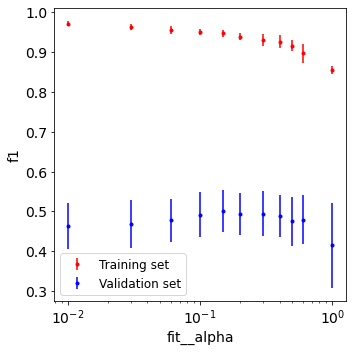

In [79]:
ml.plot_pars_scores(grid)

### Learning curve

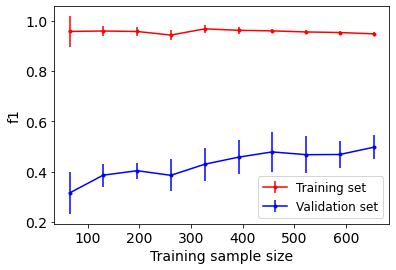

In [85]:
ml.plot_learning_curve(model, X_train, y_train, 'f1')

### Teste na amostra de teste

In [86]:
dump = model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
for metric in ['accuracy', 'f1', 'precision', 'recall']:
    mfunc = get_scorer(metric)._score_func
    print(metric + ': {:.4f}'.format(mfunc(y_test, y_test_pred)))

accuracy: 0.7982
f1: 0.5306
precision: 0.5652
recall: 0.5000


### Treinando a produção e salvando o modelo

In [96]:
# Registro da performance no teste:
dump = model.fit(X_train, y_train)
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train) 
final_score = f1_score(y_test, y_test_pred)
train_score = f1_score(y_train, y_train_pred)
print('Test score: {:.4f}'.format(final_score))
print('Train score: {:.4f}'.format(train_score))

Test score: 0.5306
Train score: 0.9408


In [97]:
# Treinando modelo no conjunto completo (de produção):
X_full, y_full = ml.Xy_split(annotated_df, 'not_the_target')
prod_model = clone(model)
dump = prod_model.fit(X_full, y_full)

In [98]:
# Salvando o modelo:
#ml.save_model('../../modelos/nb_wrong_target_classifier_v02/', model, prod_model, train_df, test_df, 'f1', train_score, final_score, package_list=['scikit-learn', 'numpy', 'pandas', 'scipy'])

### Testando modelo salvo

In [90]:
import joblib

In [91]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [99]:
# Carrega modelo:
test_model = joblib.load('../../modelos/nb_wrong_target_classifier_v02/tested_model.joblib')
prod_model = joblib.load('../../modelos/nb_wrong_target_classifier_v02/production_model.joblib')

In [100]:
# Resultados:
y_test_pred  = test_model.predict(X_test)
y_train_pred = test_model.predict(X_train) 
print('Test score: {:.4f}'.format(f1_score(y_test, y_test_pred)))
print('Train score: {:.4f}'.format(f1_score(y_train, y_train_pred)))

Test score: 0.5306
Train score: 0.9408


In [101]:
confusion_matrix(y_test, y_test_pred)

array([[156,  20],
       [ 26,  26]])

In [102]:
# Acertou que era pra outra pessoa:
xd.print_string_series(X_test.loc[(y_test_pred == 1) & (y_test == 1), 'text'])

141: @BolsonaroSP Ele é um bosta drogado
143: @IvanValente Tem que ser maluca essa mulher.
168: @verdouglasgomes Imbecil retardada.
Coitada ...
186: @carlosjordy Mas que puta rampeira! She's a cum dumpster!
191: @carteiroreaca Poderia ser varíola das pirocas.
193: @CamargoDireita Bando de esquerdista canalha 😡😡😡😡
219: @carteiroreaca Varíola dos veados. Kkkk
251: @carteiroreaca Varíola do Chupa-cu
258: @CoronelTadeu Palhaçada 
Tinha que esta preso
264: @carteiroreaca Varíola das gazelas!🤣🤣🤣
328: @CarolDeToni Safados terroristas
911: @rsallesmma Atriz de merda
966: @reportersalles Muito dinheiro gasto com carniça ladrã*.
996: @BiologoHenrique Isso é um absurdo!!! Todos temos direito a uma aposentadoria, se alcançarmos a idade.
1018: @AbrahamWeint Ele é misógino, fascista, racista, classista, homofóbico, genocida…
Nada disso é mentira
1035: @FernandaLoubac2 E assim, os companheiros criminosos dele aqui fora, vão se sentir livres para fazer o que quiserem. Pois se forem presos, sairão.
A j

In [103]:
# Acertou que era direto:
xd.print_string_series(X_test.loc[(y_test_pred == 0) & (y_test == 0), 'text'].sample(10))

1415: @Biakicis Cala a boca sua puxa saco ridícula
294: @IvanValente Vai caga idiota https://t.co/hlC2BqcjgT
1006: @soutamires_sp ✊🏼
51: @CamargoDireita Cadê o médico deste cidadão? Precisa aumentar dose ou a quantidade do remédio. É muito louco!😠
1331: @IvanValente LOOLA nunca mais https://t.co/QpxexOtgys
210: @joicehasselmann Essa mulher é esquizofrênica.
289: @GuilhermeBoulos Que bosta, vocês denovo para encher o saco ?
217: @joicehasselmann Kkkkkkkk,essa nem brasileiro acredita!Sua ridícula
90: @IvanValente Capiroto, mula sem cabeça , sacy ,piniquio ahhh não  , pinoquio não  é  brasileiro.
8: @CamargoDireita parabens


In [104]:
# Falso p/ outra pessoa:
xd.print_string_series(X_test.loc[(y_test_pred == 1) & (y_test == 0), 'text'])

40: @IvanValente Esquerda nunca mais
248: @ThiagoResiste Esquerdista é muito vagabundo mesmo
302: @H1SaiaDaMatrix Kkkkkkkkkkkk ficou pica po
431: @andrefernm Tchutchuca safada!
932: @DelegadoZucco @Direita_Network @jairbolsonaro Mitoooooooooooooooooooooooo
954: Assim como o Brasil não aguenta mais Bolsonaro, Bagé não aguenta mais a família Lara. 
É por entender que precisamos fortalecer a oposição ao bolsonarismo em Bagé que declaro meu apoio ao @DepMainardi, 13555, como deputado estadual!
982: @WilliamJacob @AndreMarinho Tem o link?
985: @samanthacavalca @FariaGiuliana Sucesso!
1015: @gleisi Vagabunda corruPTa sem moral
1036: @augustodeAB @RenanSantosMBL Estragou o velório
1053: @marcia_lucena quero em CG https://t.co/Cy4RZJtWbK
1084: @carlossampaio_ Lula está certo. Temos que fazer amizade com o inimigo, só assim livramos deles.
1403: @carmelonetobr 22 🇧🇷🇧🇷🇧🇷 🙏🙏 Bolsonaro 🇧🇷🙏🙏🙏
1419: @carteiroreaca 🙏🏼🙏🏼🙏🏼
1476: @gleisi DISSOLUÇÃO DO SUPREMO 
VINCULADO COMO "ORGÃO AUXILIAR DO CONGRESS

In [106]:
# Achou que era p/ o candidato e não era:
xd.print_string_series(X_test.loc[(y_test_pred == 0) & (y_test == 1), 'text'])

23: @BolsonaroSP @profpaulamarisa @JoseMedeirosMT @Eugenia_Assis @MLauraAssis @laderechadiario @giovannilarosa0 @segregustavo Não acreditei e tive que ir lá chegar.

É verdadeiro esse bilhete!

Vai ser burro assim lá na esquerda!

Agência de cherecagem passando vergonha!

Troquem o nome de AosFatos para AosBaralhos para não falar outra coisa.
322: @AbrahamWeint Tinha q levar muita porr@d@ na cara esse vagabundagem!
908: @carteiroreaca Esse lixo desse comuna vai queimar no inferno!!!!
946: @Jouberth19 @antoniotabet “O PT é partido de vagabundo ”.😂😂😂😂Vamos subir a tag.
951: @AbrahamWeint Está proibido dizer que bolzonaro é a TCHUCHUCA DO CENTRÃO
988: @dep_padrejoao Roubalheira
999: @GTavaresPCB Eu tô aqui morrendo de rir do liberal que não conhece o básico do marginalismo. O cara tem que ser muito burro para cair nessa….
1014: @deregomesrio Era pra ser na Harmonia, mas quando chove, precisam enfiar em algum canto. Bem, na Estudantina não dá mais. Só se travar um teto de público e parar d

### Predizendo a probabilidade

In [110]:
X_test['target_prob'] = test_model.predict_proba(X_test)[:, 0]
X_test['final_prob'] = X_test['hate_score'] * X_test['target_prob']
X_test['variacao'] = X_test['final_prob'] - X_test['hate_score']

In [112]:
X_test[['text', 'hate_score', 'target_prob', 'final_prob', 'variacao']].sort_values('variacao').head(30).style.set_properties(subset=['text'], **{'width': '1500px'})

,text,hate_score,target_prob,final_prob,variacao
191,@carteiroreaca Poderia ser varíola das pirocas.,0.838341,0.002856,0.002394,-0.835947
1015,@gleisi Vagabunda corruPTa sem moral,0.993122,0.182687,0.181430,-0.811691
264,@carteiroreaca Varíola das gazelas!🤣🤣🤣,0.760350,0.001211,0.000921,-0.759429
193,@CamargoDireita Bando de esquerdista canalha 😡😡😡😡,0.801967,0.114093,0.091499,-0.710468
186,@carlosjordy Mas que puta rampeira! She's a cum dumpster!,0.949361,0.258162,0.245089,-0.704272
219,@carteiroreaca Varíola dos veados. Kkkk,0.693937,0.000017,0.000011,-0.693926
168,@verdouglasgomes Imbecil retardada. Coitada ...,0.721338,0.103738,0.074830,-0.646507
1394,@rsallesmma Eu processava essa doidinha que chamou de fela da puts,0.909877,0.291621,0.265339,-0.644538
251,@carteiroreaca Varíola do Chupa-cu,0.840771,0.245559,0.206459,-0.634312
328,@CarolDeToni Safados terroristas,0.941481,0.335047,0.315440,-0.626040
